In [2]:
# Import required libraries and set random seeds for reproducibility.

import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import tensorflow as tf
import random as rn
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from keras import models, layers
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Reproducibility
sd = 1
os.environ['PYTHONHASHSEED'] = str(sd)
np.random.seed(sd)
rn.seed(sd)
tf.random.set_seed(sd)

# ## Data Loading
# Define the data structure and extract vibration signals from `.mat` files.

# Root directory containing data folders
root_dir = './Paderborn_PreCase1_Data'
# Class label structure
data_structure = {
    0: ("Healthy", ["K001", "K002", "K003", "K004", "K005"]),
    1: ("OR_Damage", ["KA04", "KA15", "KA16", "KA22", "KA30"]),
    2: ("IR_Damage", ["KI04", "KI14", "KI16", "KI18", "KI21"]),
}

sample_limit_per_label = {0: 256000, 1: 5120, 2: 5120}

# Extract vibration signal from .mat file
def extract_signals_df(filepath, signal="vibration"):
    signals = {"vibration": 6, "current_1": 1, "current_2": 2}
    mat = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    field = next(k for k in mat if not k.startswith("__"))
    struct = mat[field]
    X_channels = struct.X
    Y_channels = struct.Y
    v = Y_channels[signals[signal]].Data.flatten().reshape(-1, 1)
    return pd.DataFrame(v, columns=["vibration"])

# Data extraction
all_data = {0: [], 1: [], 2: []}

for label, (category, folders) in data_structure.items():
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found.")
            continue

        mat_files = [f for f in os.listdir(folder_path) if f.endswith(".mat")]
        if not mat_files:
            print(f"No .mat files found in {folder_path}")
            continue

        filename = mat_files[0]
        file_path = os.path.join(folder_path, filename)
        try:
            df = extract_signals_df(file_path, signal="vibration")
            df = df.iloc[:sample_limit_per_label[label]].copy()
            df["label"] = label
            all_data[label].append(df)
            print(f"Loaded {file_path} with {len(df)} samples.")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

# Combine all data
final_df = pd.concat([df for dfs in all_data.values() for df in dfs], ignore_index=True)
final_df.rename(columns={"vibration": "signal"}, inplace=True)
print("\nCombined data shape:", final_df.shape)
print(final_df.head())

# ## Data Preprocessing
# Group signals by label and apply sampling to create fixed-size blocks.

# Signal grouping
df_signals = final_df[["signal", "label"]].copy()
grouped_signals = [
    df_signals[df_signals['label'] == i]['signal'].values.astype(float)
    for i in sorted(df_signals['label'].unique())
]
# Sampling configuration
interval_length = 320
samples_per_block = 1600

# Sampling function
def sampling(data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(data) - 2 * ignore_points
    num_blocks = (
        round(adjusted_length / interval_length)
        - round(samples_per_block / interval_length)
        - 1
    )
    if num_blocks <= 0:
        return np.empty((0, samples_per_block))
    split_data = np.zeros([num_blocks, samples_per_block])
    for i in range(num_blocks):
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx : start_idx + samples_per_block].T
    return split_data

# Data preparation
def data_preparation(data_list, interval_length, samples_per_block):
    for count, signal in enumerate(data_list):
        split_data = sampling(signal, interval_length, samples_per_block)
        if split_data.shape[0] == 0:
            continue
        y = np.zeros([len(split_data), len(data_list)])
        y[:, count] = 1
        y1 = np.zeros([len(split_data), 1])
        y1[:, 0] = count
        if count == 0:
            X = split_data
            y_positional = y
            y_labels = y1
        else:
            X = np.append(X, split_data, axis=0)
            y_positional = np.append(y_positional, y, axis=0)
            y_labels = np.append(y_labels, y1, axis=0)
    return X, y_positional, y_labels

# Run preparation
X, y_positional, y_labels = data_preparation(grouped_signals, interval_length, samples_per_block)
print("Prepared data shape:", X.shape, y_positional.shape, y_labels.shape)
# ## Data Splitting
# Split data into training and test sets, maintaining class distribution for both original and SMOTE datasets.

def time_series_stratified_split(X, y, train_ratio=0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        y_train.append(y[train_idx])
        X_test.append(X[test_idx])
        y_test.append(y[test_idx])

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )

# Split original data
X_train, y_train, X_test, y_test = time_series_stratified_split(X, y_positional)

print("Original data split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Apply SMOTE ONLY on training set
smote = SMOTE(random_state=sd)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_classes = np.argmax(y_train, axis=1)
X_train_smote, y_train_smote_classes = smote.fit_resample(X_train_flat, y_train_classes)
X_train_smote = X_train_smote.reshape(-1, samples_per_block, 1)

# Report class distribution before and after SMOTE
print("\nClass distribution BEFORE SMOTE:", np.bincount(y_train_classes))
print("Class distribution AFTER SMOTE:", np.bincount(y_train_smote_classes))

# Prepare CNN input
y_train_onehot = tf.keras.utils.to_categorical(y_train_classes, 3)
y_train_smote_onehot = tf.keras.utils.to_categorical(y_train_smote_classes, 3)
y_test_classes = np.argmax(y_test, axis=1)
y_test_onehot = tf.keras.utils.to_categorical(y_test_classes, 3)
X_train_original = X_train.reshape(-1, samples_per_block, 1)
X_test = X_test.reshape(-1, samples_per_block, 1)

# 1D CNN Model input_shape
input_shape = (samples_per_block, 1)


# CNN Model Definition
class CNN_1D:
    def __init__(self, input_shape, num_classes):
        self.model = self.CreateModel(input_shape, num_classes)

    def CreateModel(self, input_shape, num_classes):
        model = models.Sequential([
            layers.Conv1D(16, 3, activation='relu', padding='same', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(2),
            layers.Conv1D(32, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPool1D(2),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPool1D(2),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.summary()
        return model

# Training, Validation, and Testing Pipeline
class FaultDiagnosisPipeline:
    def __init__(self, X_train, y_train_classes, X_test, y_test_classes, num_classes, input_shape, k_splits=5):
        self.X_train = X_train
        self.y_train_classes = y_train_classes
        self.X_test = X_test
        self.y_test_classes = y_test_classes
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.k_splits = k_splits

        # Storage for metrics and models
        self.fold_metrics = []
        self.best_fold_model = None
        self.best_fold_index = None
        self.test_results = None

    def train_and_validate(self):
        kfold = StratifiedKFold(n_splits=self.k_splits, shuffle=True, random_state=sd)
        best_balanced_acc = 0

        for fold, (train_idx, val_idx) in enumerate(kfold.split(self.X_train, self.y_train_classes), 1):
            model = CNN_1D(self.input_shape, self.num_classes)
            early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

            history = model.model.fit(self.X_train[train_idx], tf.keras.utils.to_categorical(self.y_train_classes[train_idx], self.num_classes),
                                      validation_data=(self.X_train[val_idx], tf.keras.utils.to_categorical(self.y_train_classes[val_idx], self.num_classes)),
                                      epochs=200, callbacks=[early_stopping], verbose=0)

            y_val_pred = np.argmax(model.model.predict(self.X_train[val_idx]), axis=1)
            y_val_true = self.y_train_classes[val_idx]

            bal_acc = balanced_accuracy_score(y_val_true, y_val_pred)
            conf_mat = confusion_matrix(y_val_true, y_val_pred)
            report = classification_report(y_val_true, y_val_pred, output_dict=True)

            self.fold_metrics.append({
                'fold': fold,
                'model': model,
                'balanced_accuracy': bal_acc,
                'confusion_matrix': conf_mat,
                'classification_report': report,
                'history': history.history
            })

            if bal_acc > best_balanced_acc:
                best_balanced_acc = bal_acc
                self.best_fold_model = model
                self.best_fold_index = fold

    def test_evaluate(self):
        y_test_pred = np.argmax(self.best_fold_model.model.predict(self.X_test), axis=1)
        conf_mat_test = confusion_matrix(self.y_test_classes, y_test_pred)
        report_test = classification_report(self.y_test_classes, y_test_pred, output_dict=True)

        self.test_results = {
            'confusion_matrix': conf_mat_test,
            'classification_report': report_test,
            'y_pred': y_test_pred
        }

    def plot_best_fold_confusion(self):
        metrics = self.fold_metrics[self.best_fold_index - 1]
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Best Fold ({self.best_fold_index}) Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def plot_test_confusion(self):
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title('Test Set Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def plot_training_history(self):
        for metrics in self.fold_metrics:
            history = metrics['history']
            plt.plot(history['accuracy'], label=f'Fold {metrics["fold"]} Train Acc')
            plt.plot(history['val_accuracy'], label=f'Fold {metrics["fold"]} Val Acc')
        plt.legend()
        plt.title('Training and Validation Accuracy per Fold')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()



Loaded ./Paderborn_PreCase1_Data/K001/N15_M07_F04_K001_13.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K002/N09_M07_F10_K002_2.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K003/N09_M07_F10_K003_1.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K004/N09_M07_F10_K004_2.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/K005/N09_M07_F10_K005_1.mat with 256000 samples.
Loaded ./Paderborn_PreCase1_Data/KA04/N09_M07_F10_KA04_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA15/N09_M07_F10_KA15_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA16/N09_M07_F10_KA16_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA22/N09_M07_F10_KA22_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KA30/N09_M07_F10_KA30_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KI04/N09_M07_F10_KI04_1.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_Data/KI14/N09_M07_F10_KI14_2.mat with 5120 samples.
Loaded ./Paderborn_PreCase1_D

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


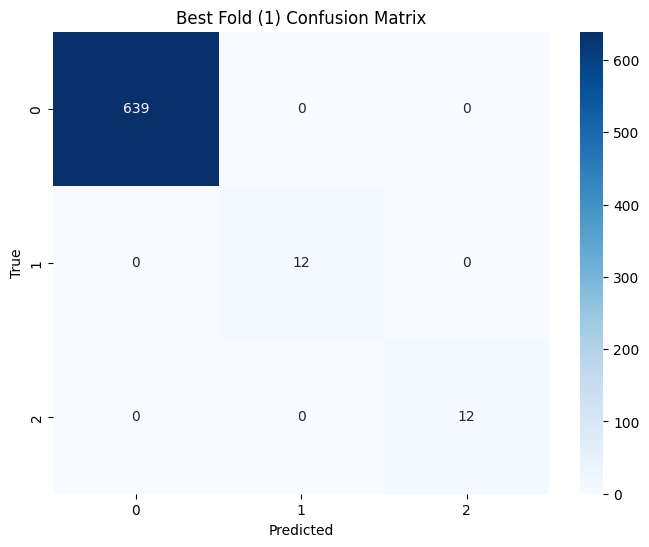

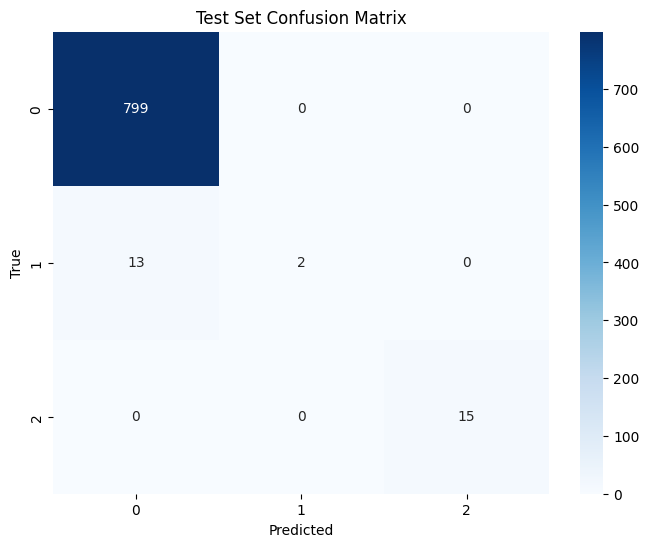

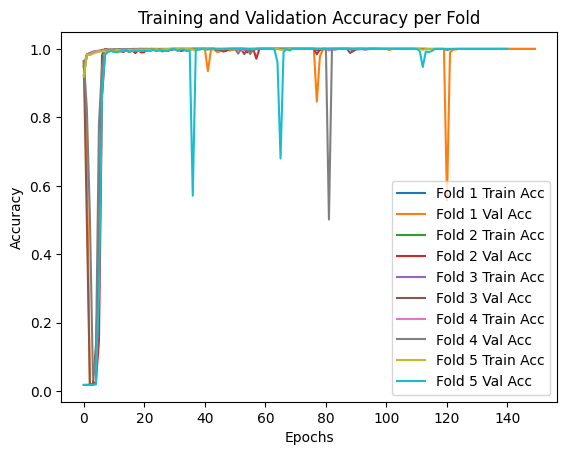

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,643 (49.39 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 224 (896.00 B)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


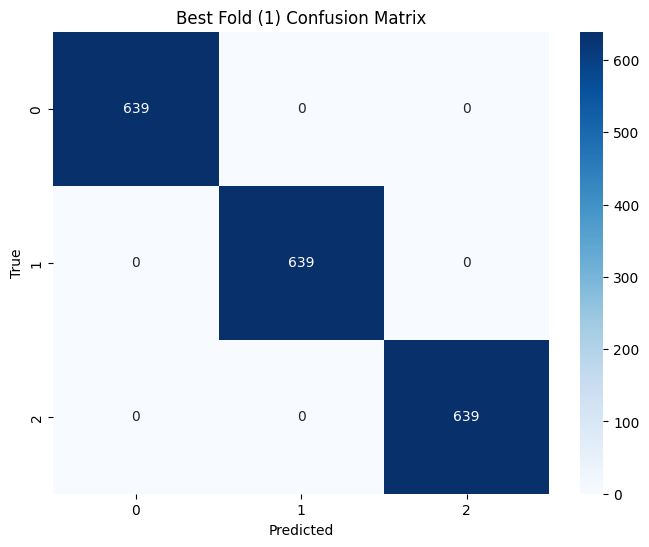

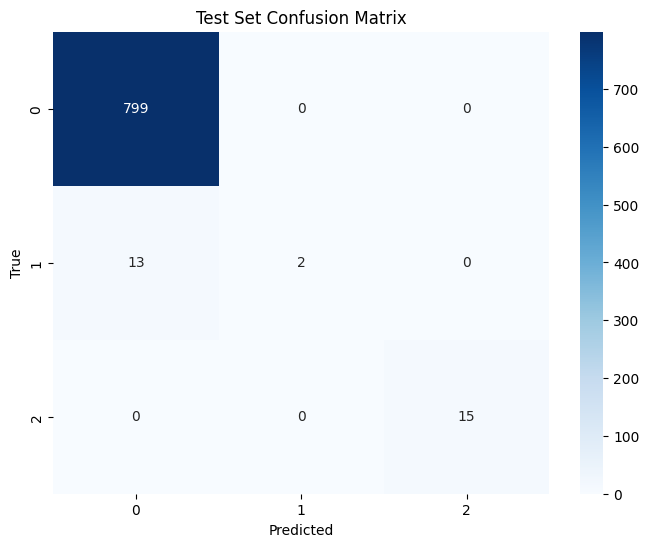

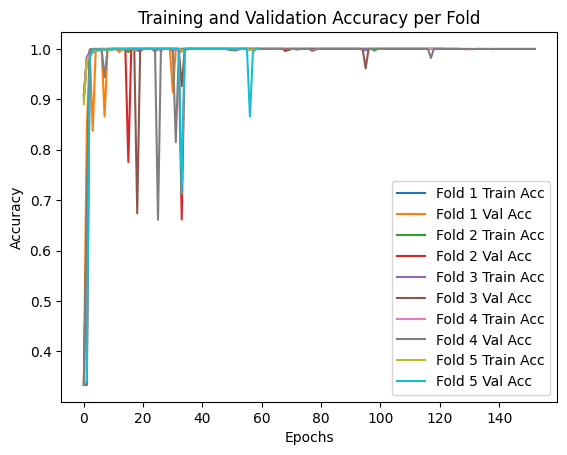

In [3]:
# For Original Training Data
pipeline_original = FaultDiagnosisPipeline(X_train_original, y_train_classes, X_test, y_test_classes, num_classes=3, input_shape=input_shape)
pipeline_original.train_and_validate()
pipeline_original.test_evaluate()
pipeline_original.plot_best_fold_confusion()
pipeline_original.plot_test_confusion()
pipeline_original.plot_training_history()

# For SMOTE-augmented Training Data
pipeline_smote = FaultDiagnosisPipeline(X_train_smote, y_train_smote_classes, X_test, y_test_classes, num_classes=3, input_shape=input_shape)
pipeline_smote.train_and_validate()
pipeline_smote.test_evaluate()
pipeline_smote.plot_best_fold_confusion()
pipeline_smote.plot_test_confusion()
pipeline_smote.plot_training_history()

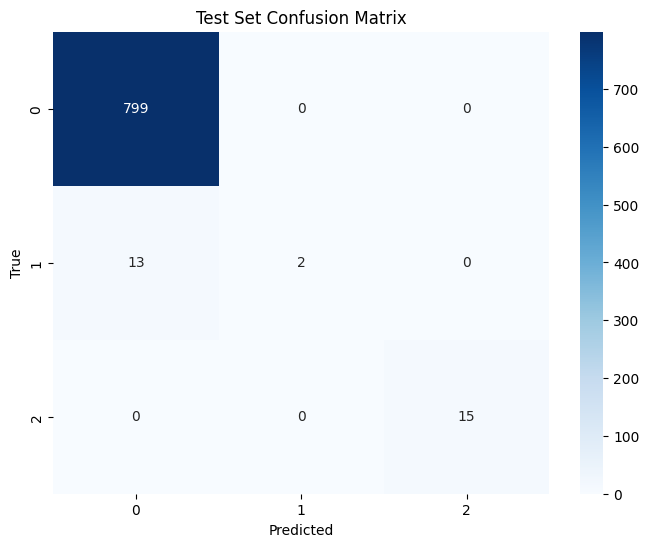

In [5]:
pipeline_original.plot_test_confusion()

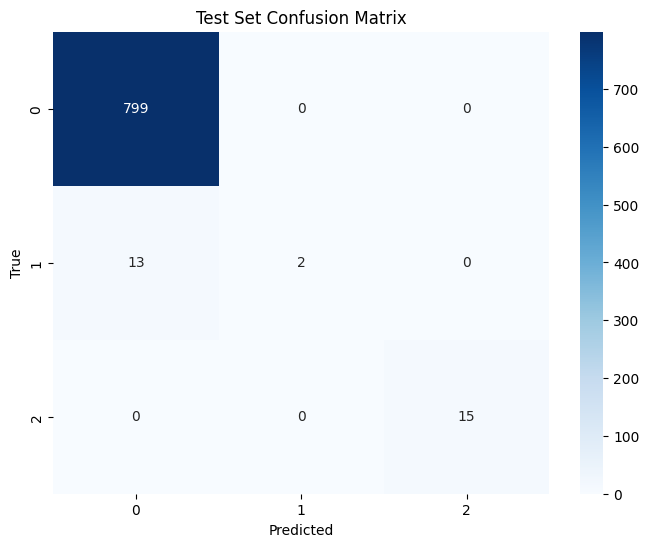

In [10]:
pipeline_smote.plot_test_confusion()

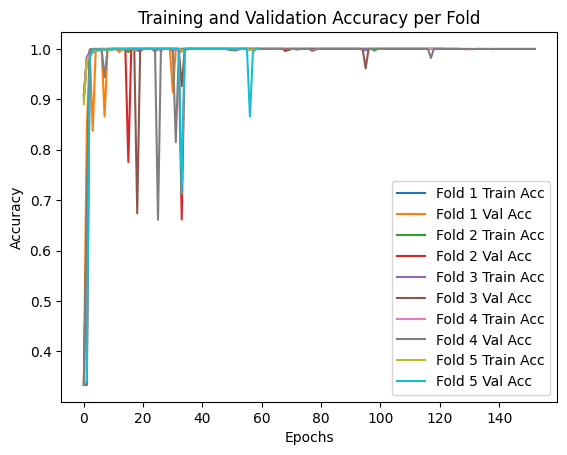

In [8]:
pipeline_smote.plot_training_history()